# Support for spatial transcriptomics

For more information on the support for spatial transcriptomics, please see the [SPArrOW documentation](https://sparrow-pipeline.readthedocs.io/en/latest). Harpy focusses on the analysis of spatial proteomics data and extends the SPArrOW pipeline to support highly-multiplexed images.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import harpy

/Users/arnedf/miniconda3/envs/harpy_20_5_25/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/arnedf/miniconda3/envs/harpy_20_5_25/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)




Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.3 
platform:       	darwin 
python version: 	3.12.10 
torch version:  	2.7.0! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




2025-05-22 09:58:36,689 - harpy.image.segmentation.segmentation_models._instanseg - WARNING - Module 'instanseg' not installed, please install 'instanseg' (https://github.com/instanseg/instanseg) if you want to use the callable 'harpy.im.instanseg_callable' as model for 'harpy.im.segment'.
/Users/arnedf/miniconda3/envs/harpy_20_5_25/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


## 1. Read in the data

The first step includes reading in the raw data.

The example dataset for this notebook will be downloaded and cached using `pooch` via `harpy.dataset.registry`.


### Convert to zarr and read the image


In [3]:
import os
import tempfile
import uuid

from harpy.datasets.registry import get_registry

# change this path. It is the directory where the spatialdata .zarr will be saved.
OUTPUT_DIR = tempfile.gettempdir()

img_layer = "raw_image"

path = None  # If None, example data will be downloaded in the default cache folder of your os. Set this to a custom path, to change this behaviour.
registry = get_registry(path=path)
path_image = registry.fetch("transcriptomics/resolve/mouse/20272_slide1_A1-1_DAPI.tiff")

# you can choose any name for your zarr file
zarr_path = os.path.join(OUTPUT_DIR, f"sdata_{uuid.uuid4()}.zarr")

sdata = harpy.io.create_sdata(
    input=path_image,
    output_path=zarr_path,
    img_layer=img_layer,
    chunks=1024,
)

INFO     The Zarr backing store has been changed from None the new file path:                                      
         /var/folders/q5/7yhs0l6d0x771g7qdbhvkvmr0000gp/T/sdata_c927721e-2b3f-4223-8bdb-79b4a8e9c059.zarr          


/Users/arnedf/miniconda3/envs/harpy_20_5_25/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
2025-05-22 09:58:37,641 - harpy.image._manager - INFO - Writing results to layer 'raw_image'
version mismatch: detected: RasterFormatV02, requested: FormatV04


## 2. Plot the image


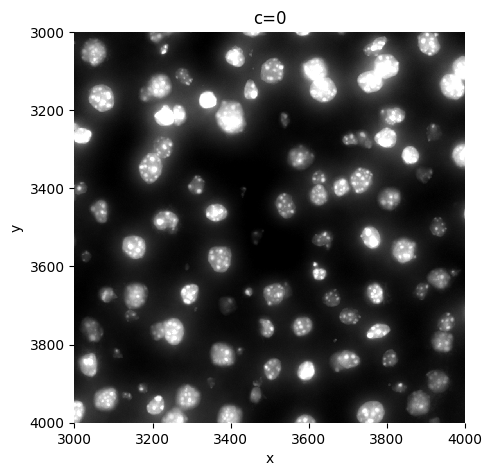

In [4]:
harpy.pl.plot_image(
    sdata,
    img_layer="raw_image",
    crd=[3000, 4000, 3000, 4000],  # region to plot [x_min, xmax, y_min, y_max]
    figsize=(5, 5),
)

## 3. Segment using Cellpose


In [8]:
from packaging import version

import cellpose
import torch
from dask.distributed import Client, LocalCluster

from harpy.image import cellpose_callable

cellpose_version = version.parse(cellpose.version)

if torch.backends.mps.is_available() and cellpose_version >= version.parse("4.0"):  # mps bugged in cellpose < 4.0
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Using device: {device}.")

cluster = LocalCluster(
    n_workers=8
    if device == "cpu"
    else 1,  # if cuda or mps device available, it is better to increase chunk size to maximal value that fits on the gpu, and set n_workers to 1.
    threads_per_worker=1,
    memory_limit="32GB",
)

client = Client(cluster)

print(client.dashboard_link)

sdata = harpy.im.segment(
    sdata,
    img_layer="raw_image",
    depth=200,
    model=cellpose_callable,
    # parameters that will be passed to the callable cellpose_callable
    pretrained_model="nuclei",
    diameter=50,
    flow_threshold=0.9,
    cellprob_threshold=-4,
    output_labels_layer="segmentation_mask",
    output_shapes_layer="segmentation_mask_boundaries",
    device=device,
    crd=[3000, 4000, 3000, 4000],  # region to segment [x_min, xmax, y_min, y_max],
    overwrite=True,
)
client.close()

Using device: mps.


/Users/arnedf/miniconda3/envs/harpy_20_5_25/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50427 instead
  warnings.warn(


http://127.0.0.1:50427/status


/Users/arnedf/miniconda3/envs/harpy_20_5_25/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/arnedf/miniconda3/envs/harpy_20_5_25/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)




Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.3 
platform:       	darwin 
python version: 	3.12.10 
torch version:  	2.7.0! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




2025-05-22 10:00:45,143 - harpy.image.segmentation.segmentation_models._instanseg - WARNING - Module 'instanseg' not installed, please install 'instanseg' (https://github.com/instanseg/instanseg) if you want to use the callable 'harpy.im.instanseg_callable' as model for 'harpy.im.segment'.
/Users/arnedf/miniconda3/envs/harpy_20_5_25/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
pretrained model /Users/arnedf/.cellpose/models/cpsam not found, using default model
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
/Users/arnedf/miniconda3/envs/harpy_20_5_25/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
2025-05-22 10:00:58,013 - harpy.image.segmentation._segmentati

## 4. Visualize resulting segmentation


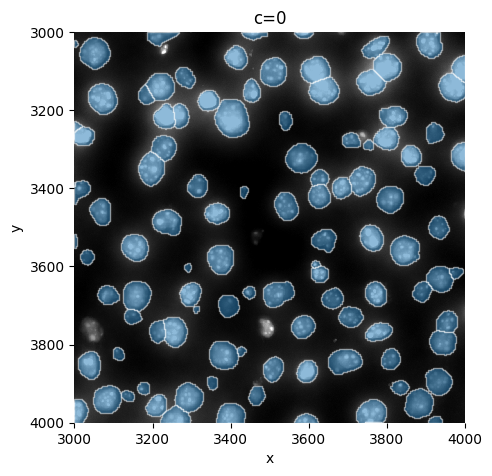

In [9]:
harpy.pl.plot_shapes(
    sdata,
    img_layer="raw_image",
    shapes_layer="segmentation_mask_boundaries",
    crd=[3000, 4000, 3000, 4000],
    figsize=(5, 5),
)